### ARC 2024 Competition Data Unsupervised Learning

In [1]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


### Clustering NN Training

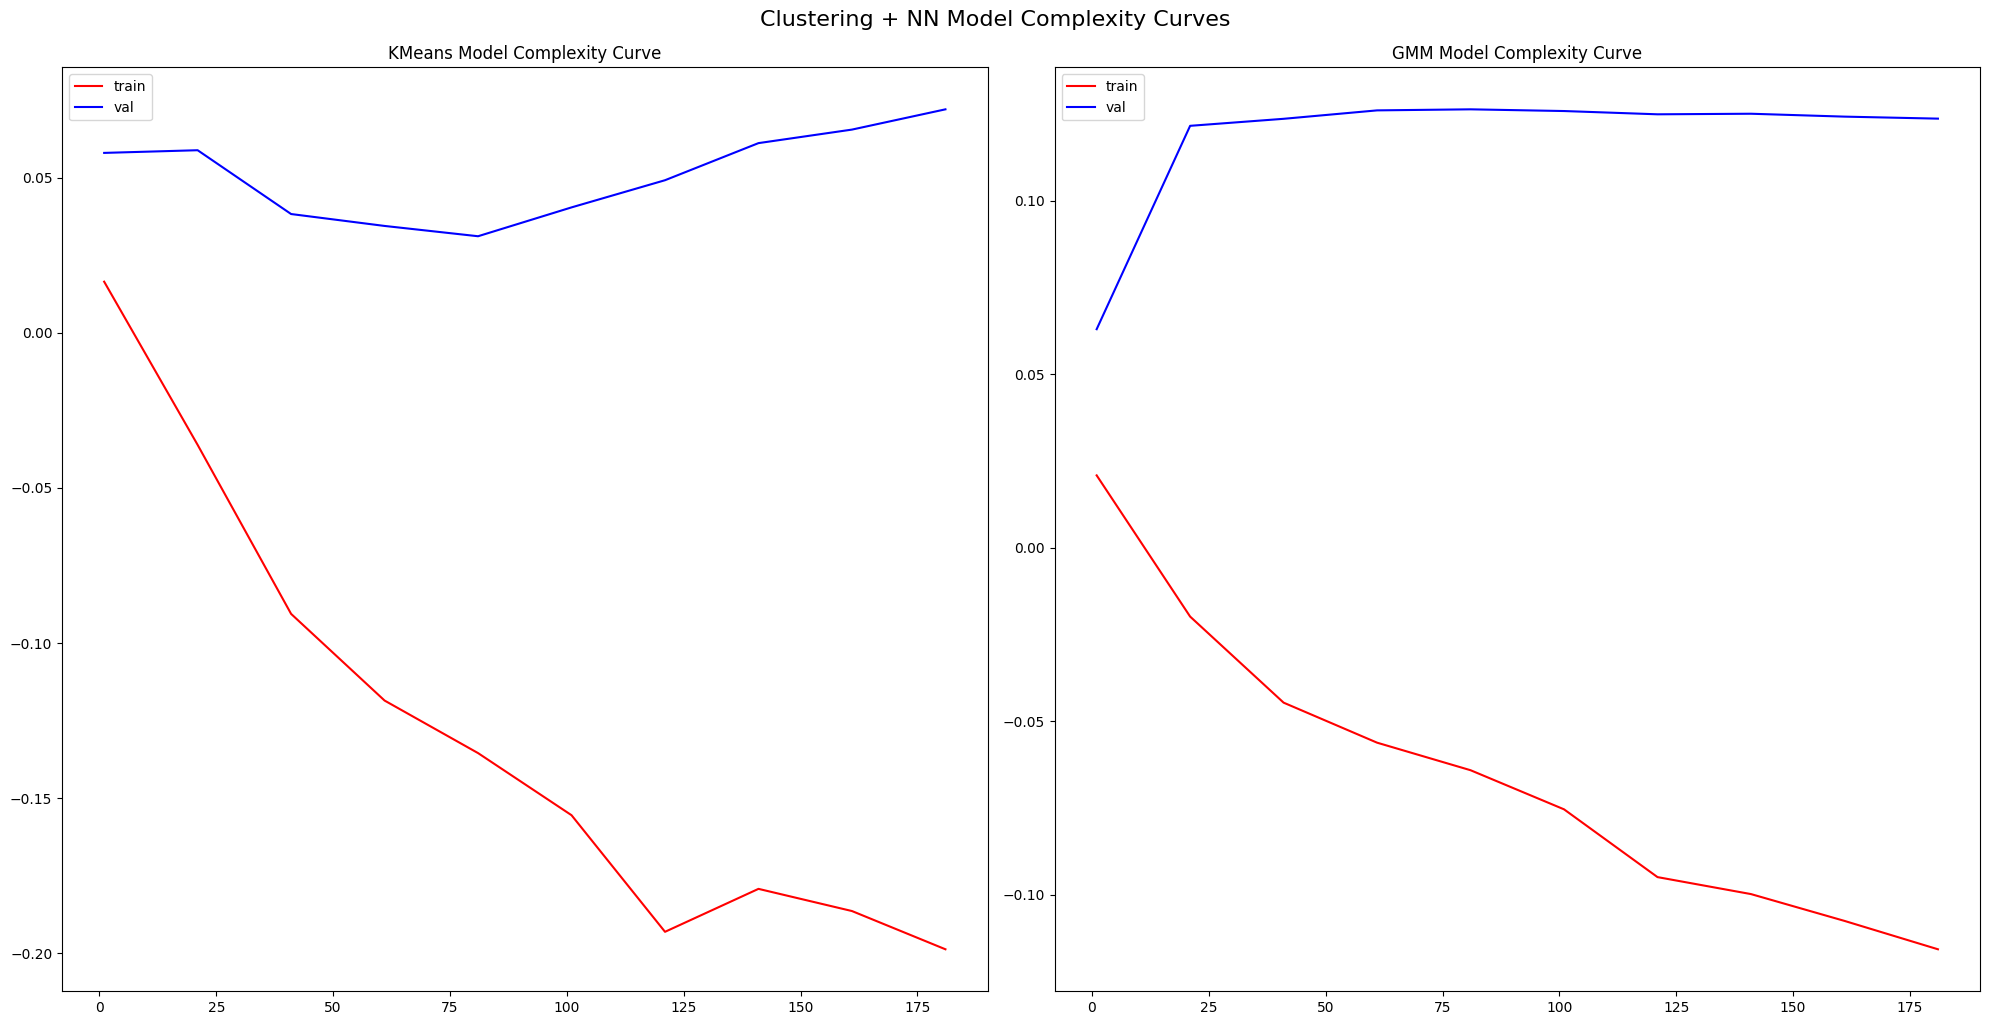

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, silhouette_score
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def load_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

def prepare_data(challenges, sample_ratio=1.00):
    data = []
    labels = []
    for task_id, task in challenges.items():
        for instance in task['train']:
            input_matrix = np.array(instance['input'])
            output_matrix = np.array(instance['output'])
            if input_matrix.shape == output_matrix.shape:
                # Merge nested lists into one flat list
                input_flat = sum([sublist.tolist() for sublist in input_matrix if sublist.size > 0], [])
                output_flat = sum([sublist.tolist() for sublist in output_matrix if sublist.size > 0], [])
                data.append(input_flat)
                labels.append(output_flat)
    
    if len(data) == 0 or len(labels) == 0:
        raise ValueError("No data available after filtering for shape matching.")

    max_length = max(max(len(d) for d in data), max(len(l) for l in labels))
    data = np.array([np.pad(d, (0, max_length - len(d)), 'constant') for d in data], dtype=object)
    labels = np.array([np.pad(l, (0, max_length - len(l)), 'constant') for l in labels], dtype=object)
    data = np.array(data.tolist())
    labels = np.array(labels.tolist())
    sample_size = int(len(data) * sample_ratio)
    if sample_size < 2:
        raise ValueError("Sample size after filtering is too small. Increase the sample_ratio or ensure sufficient data.")
    indices = np.random.choice(len(data), sample_size, replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

def apply_clustering(X, method):
    if method == 'KMeans':
        model = KMeans(n_clusters=3, random_state=42)
    elif method == 'GMM':
        model = GaussianMixture(n_components=3, random_state=42)
    else:
        raise ValueError(f"Unknown clustering method: {method}")
    clusters = model.fit_predict(X)
    return clusters

def train_nn(X_train, X_test, y_train, y_test, hidden_layers=(200,), max_iter=500):
    nn = MLPRegressor(hidden_layer_sizes=hidden_layers, max_iter=max_iter, random_state=42)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return nn, mse

def plot_model_complexity_curve_grid(ax, method, is_clustering=False):
    if is_clustering:
        clusters = apply_clustering(X_train, method)
        clusters_test = apply_clustering(X_test, method)
        X_train_reduced = clusters.reshape(-1, 1)
        X_test_reduced = clusters_test.reshape(-1, 1)
    else:
        X_train_reduced = apply_dimensionality_reduction(X_train, method)
        X_test_reduced = apply_dimensionality_reduction(X_test, method)
    nn = MLPRegressor(hidden_layer_sizes=(200,), max_iter=500, random_state=42)
    param_range = np.arange(1, 201, 20)
    train_scores, val_scores = validation_curve(
        nn, X_train_reduced, y_train, param_name="hidden_layer_sizes", param_range=param_range, cv=5)
    train_errors = -train_scores.mean(axis=1)
    val_errors = -val_scores.mean(axis=1)
    ax.plot(param_range, train_errors, 'r-', label='train')
    ax.plot(param_range, val_errors, 'b-', label='val')
    ax.set_title(f"{method} Model Complexity Curve")
    ax.legend()

def plot_in_grid(methods, plot_function, rows, cols, title_prefix, is_clustering=False):
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
    axs = axs.flatten()
    for i, method in enumerate(methods):
        plot_function(axs[i], method, is_clustering=is_clustering)
    for ax in axs[len(methods):]:
        fig.delaxes(ax)
    plt.tight_layout()
    plt.suptitle(f"{title_prefix}", y=1.02, fontsize=16)
    plt.show()

# Load the data
base_path = '/kaggle/input/arc-prize-2024/'
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Prepare the training data
train_data, train_labels = prepare_data(training_challenges, sample_ratio=1.00)

# Ensure we have sufficient data for training and testing
if len(train_data) < 2:
    raise ValueError("Not enough data for training and testing. Please adjust the sample ratio.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Plot model complexity curves for clustering methods
clustering_methods = ['KMeans', 'GMM']
plot_in_grid(clustering_methods, plot_model_complexity_curve_grid, 1, 2, "Clustering + NN Model Complexity Curves", is_clustering=True)


### Dimensionality Reduction and Non-Linear Manifold Learning Training

### Baseline NN, Clustering, and Dimensionality Reduction on Data

Baseline MLP mean squared error: 0.81


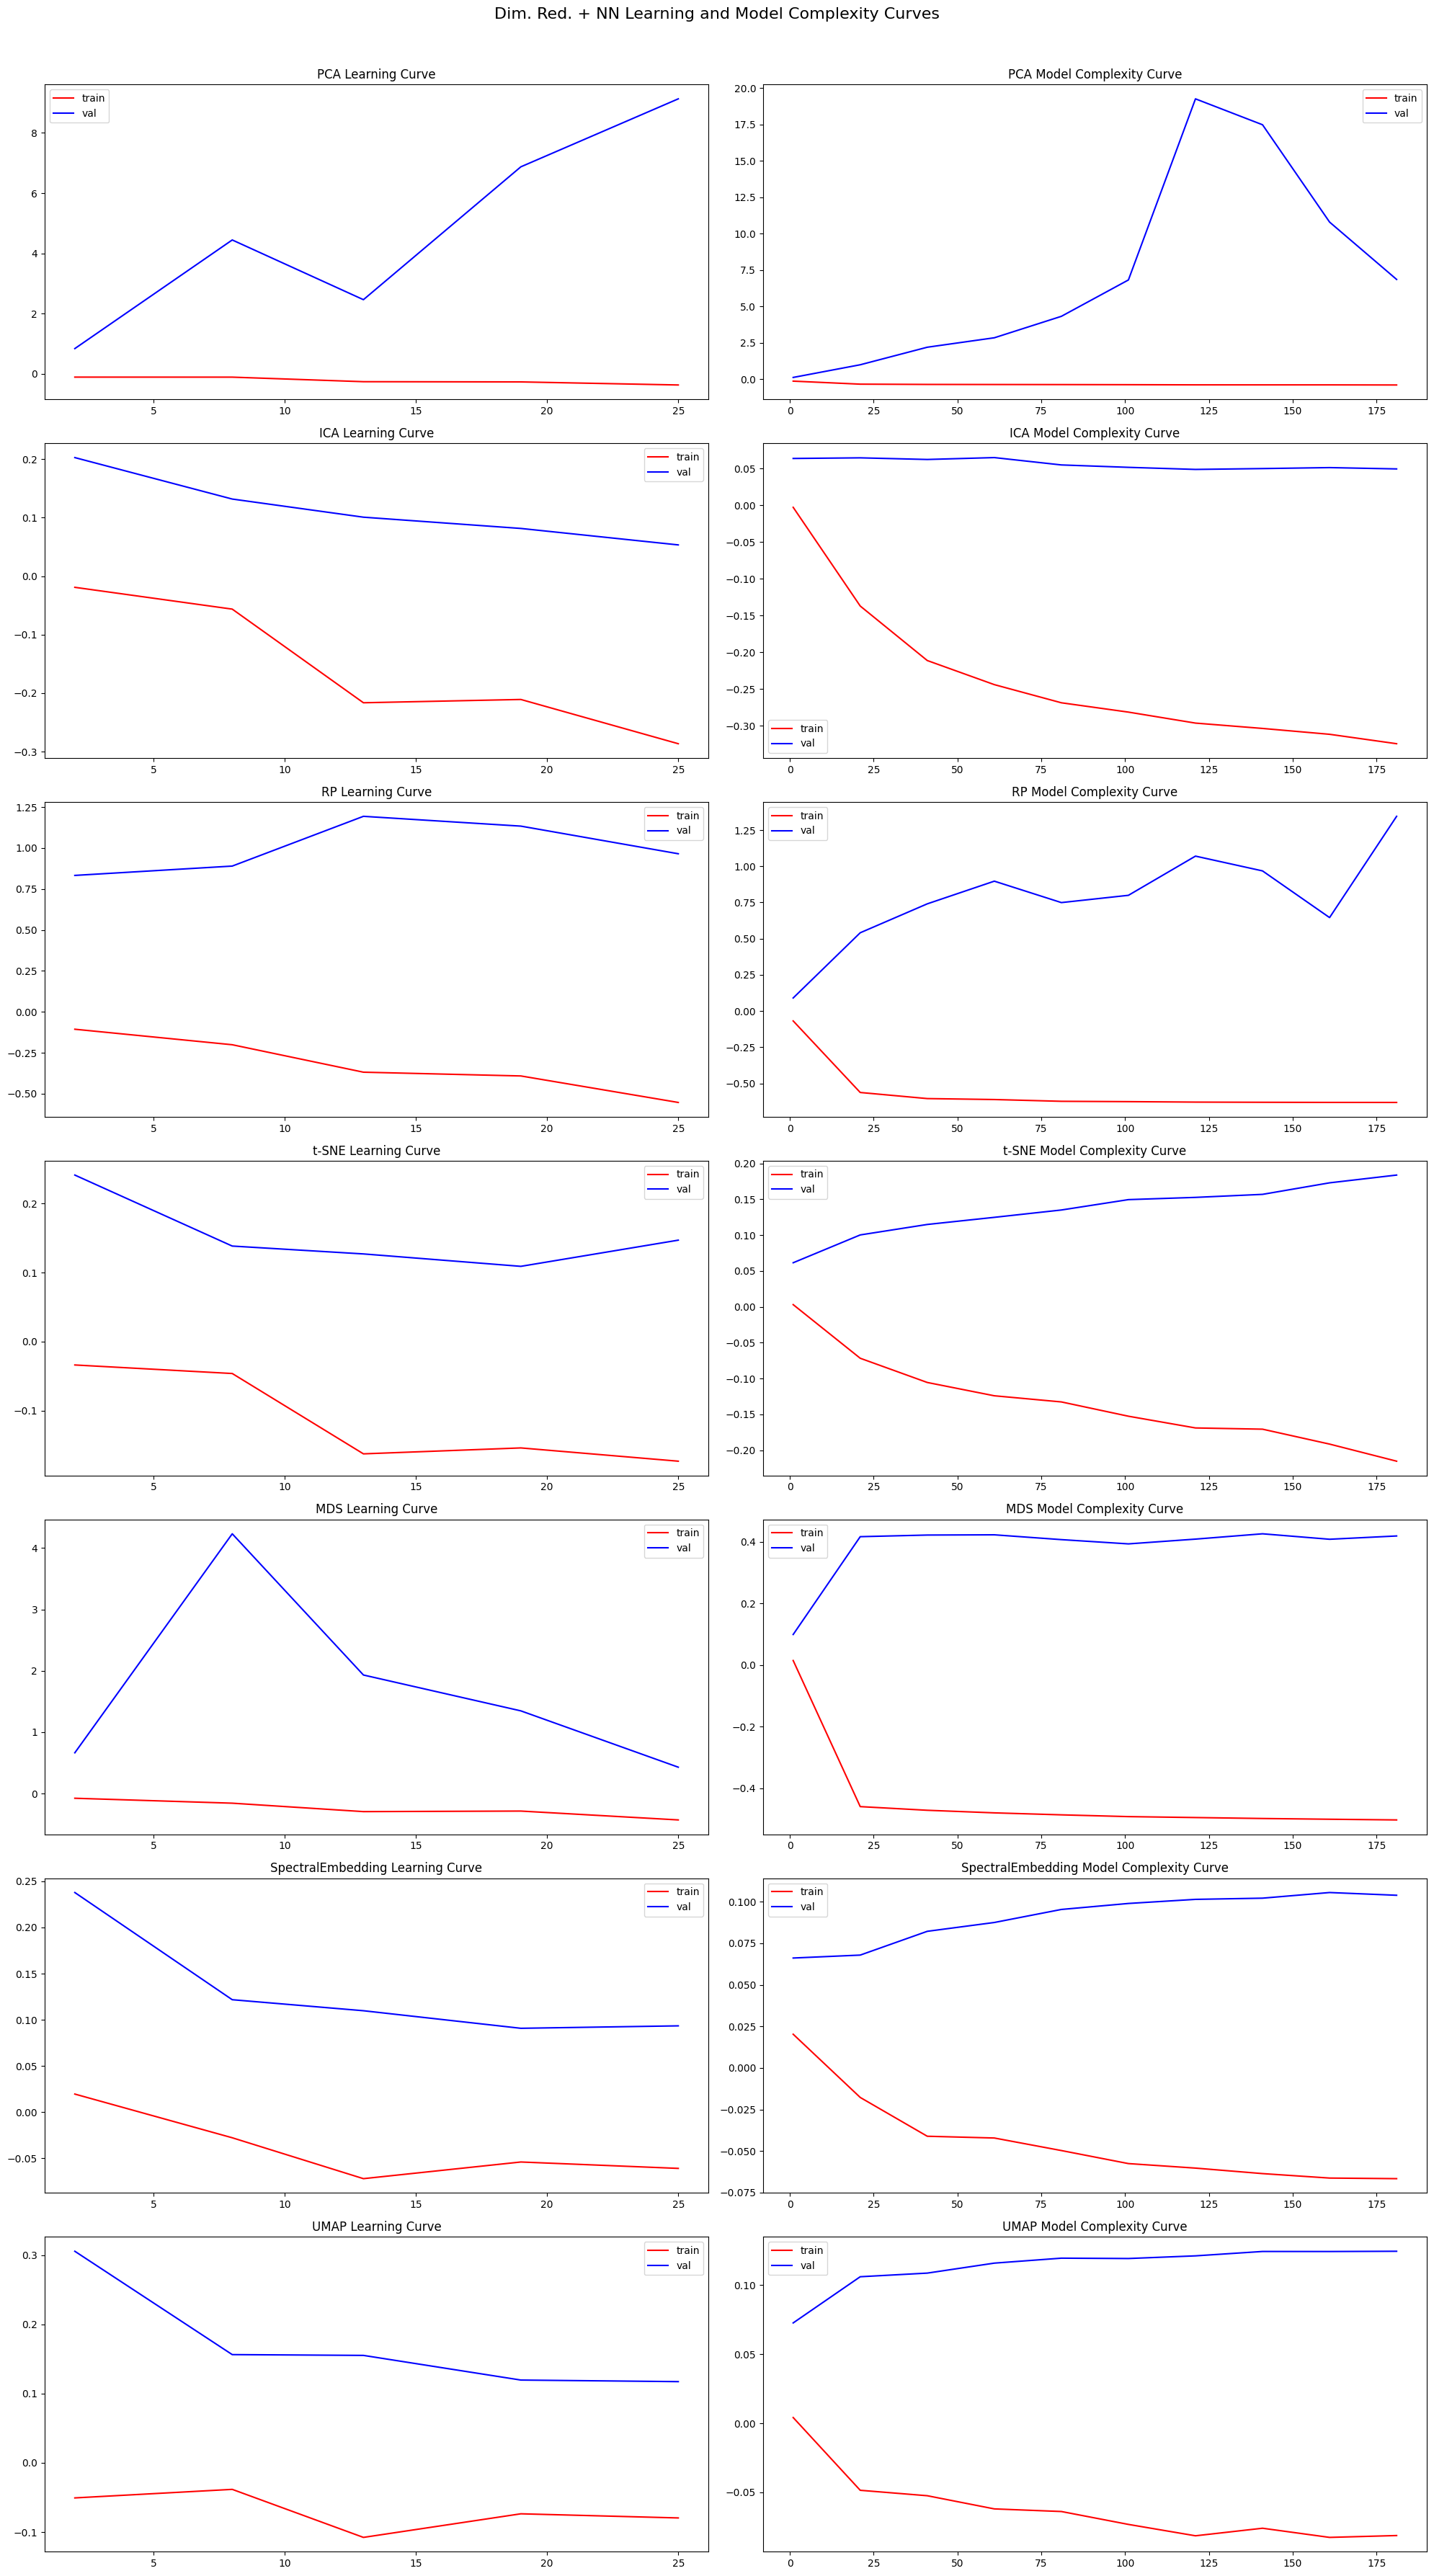

In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def load_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

def prepare_data(challenges, sample_ratio=1.00):
    data = []
    labels = []
    for task_id, task in challenges.items():
        for instance in task['train']:
            input_matrix = np.array(instance['input'])
            output_matrix = np.array(instance['output'])
            if input_matrix.shape == output_matrix.shape:
                input_flat = sum([sublist.tolist() for sublist in input_matrix if sublist.size > 0], [])
                output_flat = sum([sublist.tolist() for sublist in output_matrix if sublist.size > 0], [])
                data.append(input_flat)
                labels.append(output_flat)
    
    if len(data) == 0 or len(labels) == 0:
        raise ValueError("No data available after filtering for shape matching.")

    max_length = max(max(len(d) for d in data), max(len(l) for l in labels))
    data = np.array([np.pad(d, (0, max_length - len(d)), 'constant') for d in data], dtype=object)
    labels = np.array([np.pad(l, (0, max_length - len(l)), 'constant') for l in labels], dtype=object)
    data = np.array(data.tolist())
    labels = np.array(labels.tolist())
    sample_size = int(len(data) * sample_ratio)
    if sample_size < 2:
        raise ValueError("Sample size after filtering is too small. Increase the sample_ratio or ensure sufficient data.")
    indices = np.random.choice(len(data), sample_size, replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

def apply_dimensionality_reduction(X, method, n_components=2):
    if method == 'PCA':
        dr = PCA(n_components=n_components)
    elif method == 'ICA':
        dr = FastICA(n_components=n_components)
    elif method == 'RP':
        dr = GaussianRandomProjection(n_components=min(X.shape[1], 50))
    elif method == 't-SNE':
        perplexity = min(30, X.shape[0] - 1)
        dr = TSNE(n_components=n_components, perplexity=perplexity)
    elif method == 'MDS':
        dr = MDS(n_components=n_components)
    elif method == 'SpectralEmbedding':
        dr = SpectralEmbedding(n_components=n_components)
    elif method == 'UMAP':
        import umap
        dr = umap.UMAP(n_components=n_components)
    else:
        raise ValueError(f"Unknown method: {method}")
    X_reduced = dr.fit_transform(X)
    return X_reduced

def train_nn(X_train, X_test, y_train, y_test, hidden_layers=(200,), max_iter=500):
    nn = MLPRegressor(hidden_layer_sizes=hidden_layers, max_iter=max_iter, random_state=42)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return nn, mse

def plot_learning_curve(ax, X_train, y_train, method):
    nn = MLPRegressor(hidden_layer_sizes=(200,), max_iter=500, random_state=42)
    train_sizes, train_scores, val_scores, fit_times, _ = learning_curve(
        nn, X_train, y_train, cv=5, return_times=True)
    train_errors = -train_scores.mean(axis=1)
    val_errors = -val_scores.mean(axis=1)
    ax.plot(train_sizes, train_errors, 'r-', label='train')
    ax.plot(train_sizes, val_errors, 'b-', label='val')
    ax.set_title(f"{method} Learning Curve")
    ax.legend()

def plot_model_complexity_curve(ax, X_train, y_train, method):
    nn = MLPRegressor(hidden_layer_sizes=(200,), max_iter=500, random_state=42)
    param_range = np.arange(1, 201, 20)
    train_scores, val_scores = validation_curve(
        nn, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range, cv=5)
    train_errors = -train_scores.mean(axis=1)
    val_errors = -val_scores.mean(axis=1)
    ax.plot(param_range, train_errors, 'r-', label='train')
    ax.plot(param_range, val_errors, 'b-', label='val')
    ax.set_title(f"{method} Model Complexity Curve")
    ax.legend()

def plot_combined_learning_curves(methods, X_train, y_train, title_prefix):
    fig, axs = plt.subplots(len(methods), 2, figsize=(20, 5 * len(methods)))
    for i, method in enumerate(methods):
        X_train_reduced = apply_dimensionality_reduction(X_train, method)
        plot_learning_curve(axs[i, 0], X_train_reduced, y_train, method)
        plot_model_complexity_curve(axs[i, 1], X_train_reduced, y_train, method)
    plt.tight_layout()
    plt.suptitle(f"{title_prefix}", y=1.02, fontsize=16)
    plt.show()

# Load the data
base_path = '/kaggle/input/arc-prize-2024/'
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Prepare the training data
train_data, train_labels = prepare_data(training_challenges, sample_ratio=1.0)

# Ensure we have sufficient data for training and testing
if len(train_data) < 2:
    raise ValueError("Not enough data available for training and testing. Please check the data preparation steps.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Step 4: Run dim. red. and compare to baseline NN, then perform analysis (NN)
baseline_nn, baseline_mse = train_nn(X_train, X_test, y_train, y_test)
print(f"Baseline MLP mean squared error: {baseline_mse:.2f}")

# Compare NN with all DR methods
dr_methods = ['PCA', 'ICA', 'RP', 't-SNE', 'MDS', 'SpectralEmbedding', 'UMAP']
plot_combined_learning_curves(dr_methods, X_train, y_train, "Dim. Red. + NN Learning and Model Complexity Curves")


### Step 3. Dimensionality Reduction, then Clustering

Baseline MLP mean squared error: 0.55


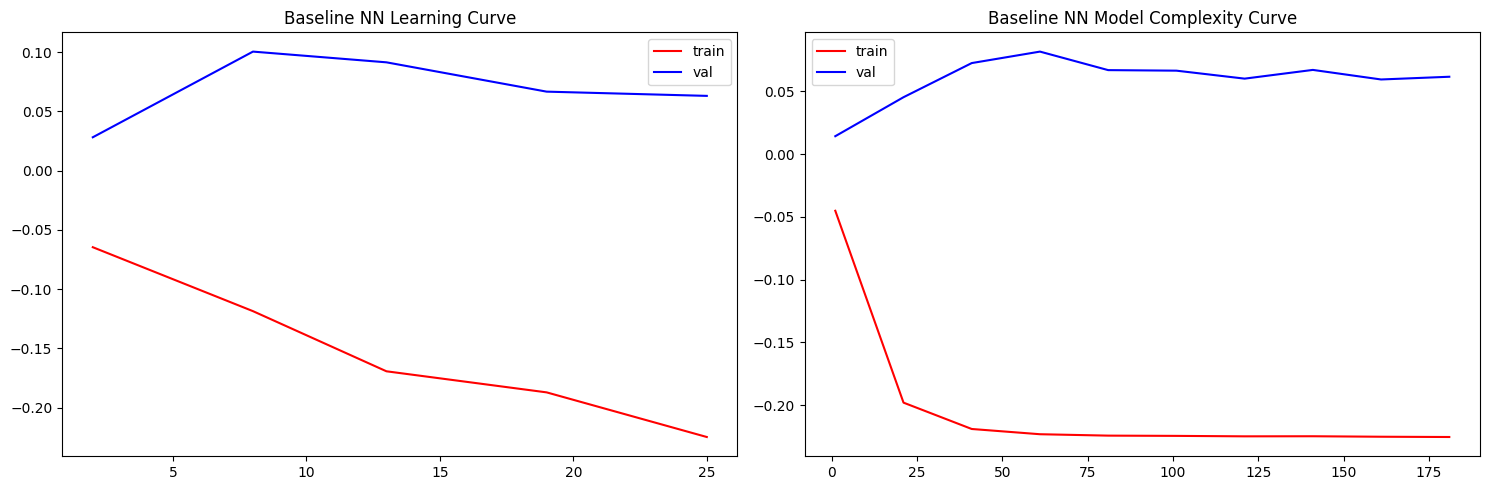

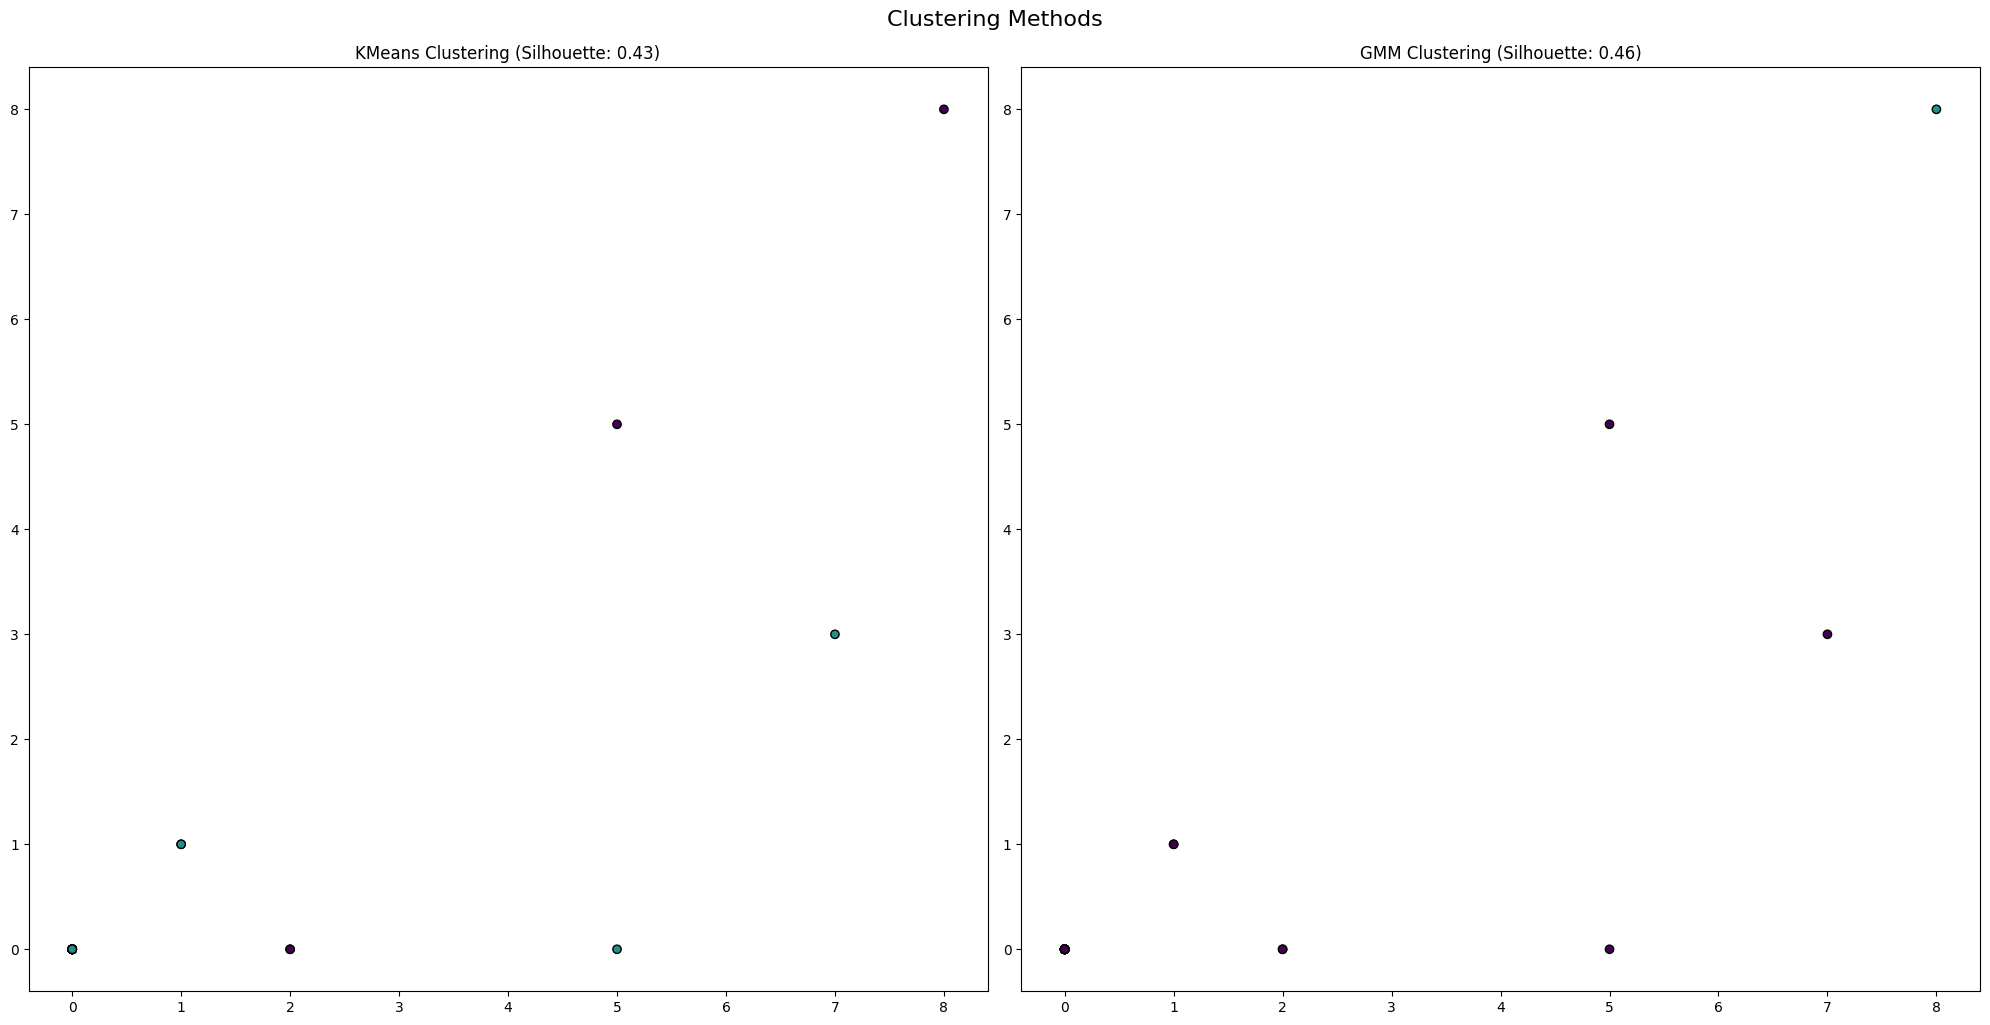

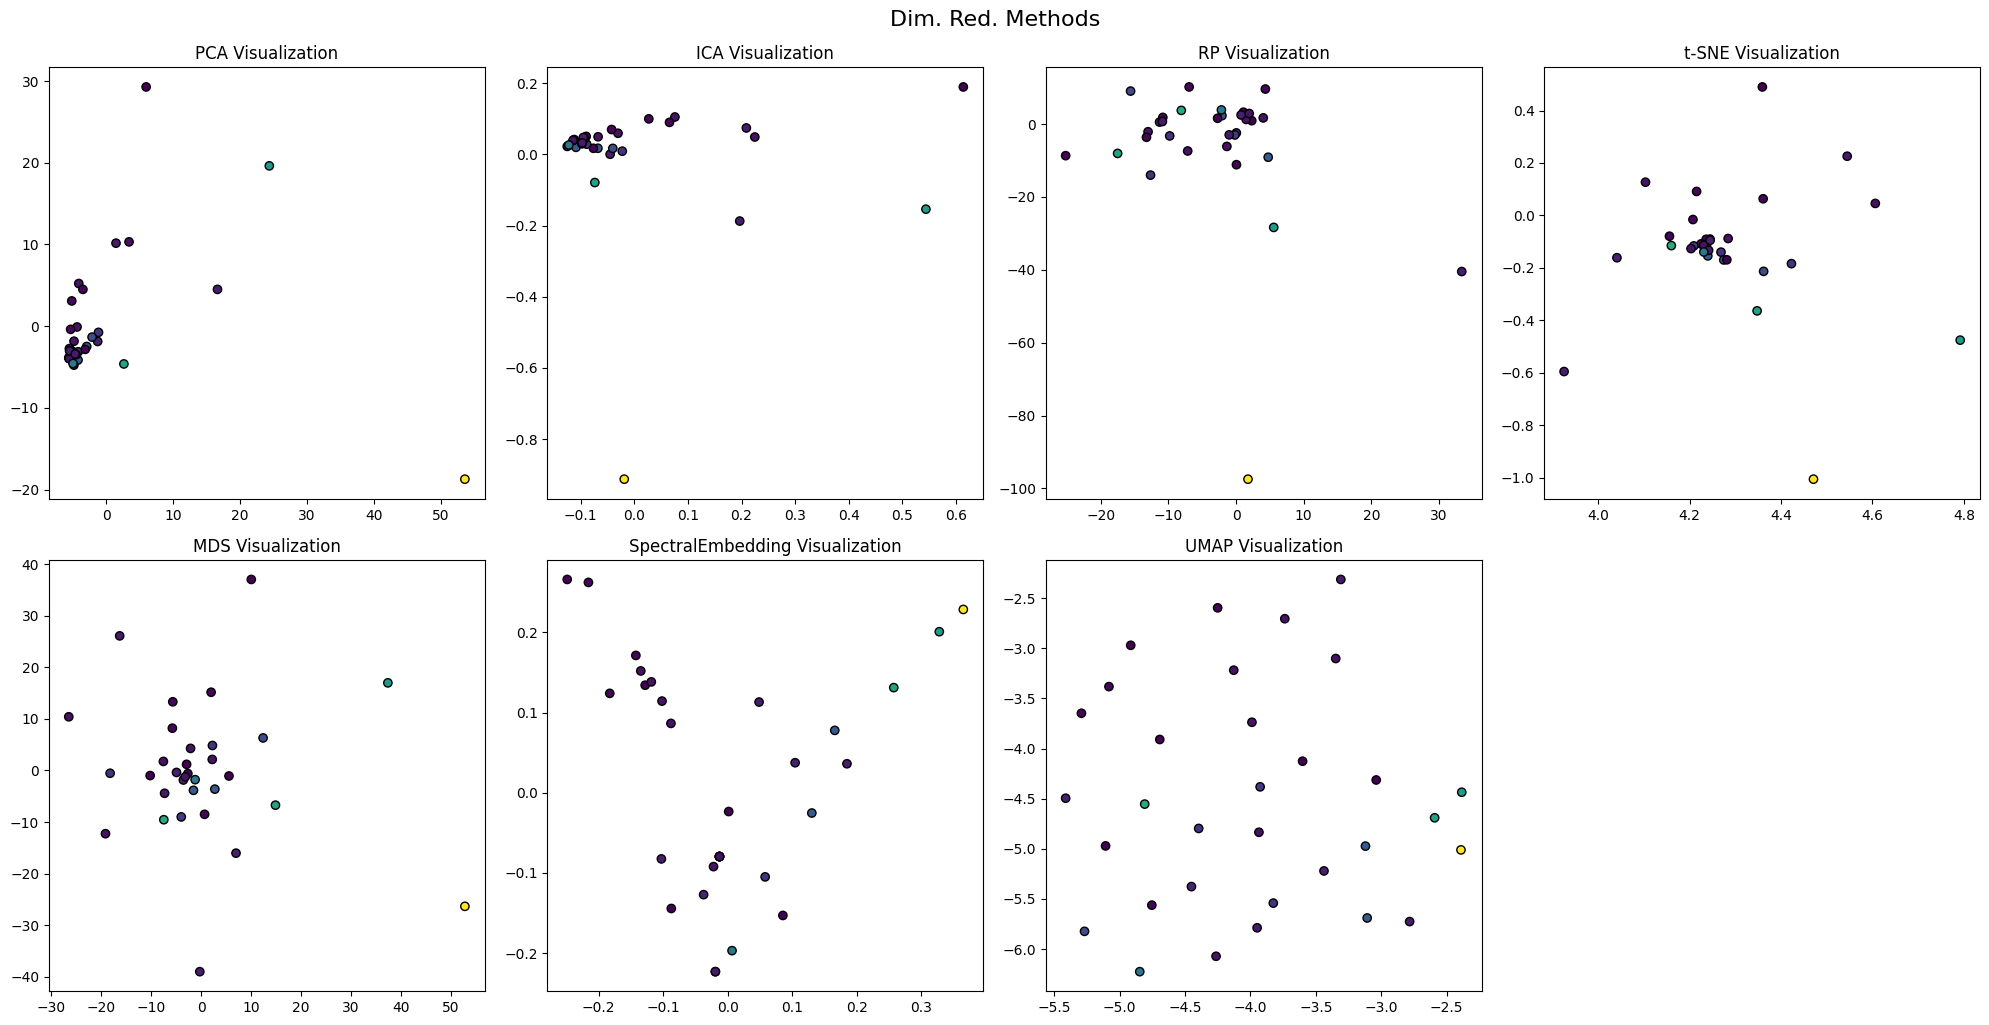

Best number of components for PCA: 16
Best number of components for ICA: 20
Best number of components for RP: 1
PCA Explained Variance Ratio: [3.21096120e-01 1.58063112e-01 1.01145973e-01 8.03972782e-02
 6.31836441e-02 4.69199242e-02 3.42707636e-02 3.14050503e-02
 2.70877326e-02 2.13623192e-02 1.91457031e-02 1.39831098e-02
 1.28188906e-02 9.45428318e-03 7.92391241e-03 7.49954080e-03
 7.13984250e-03 6.44755666e-03 5.72009512e-03 5.15367932e-03
 4.71219522e-03 4.24713177e-03 3.19149136e-03 2.15813865e-03
 2.02212245e-03 1.43311812e-03 8.41062716e-04 6.71358881e-04
 2.47789732e-04 1.79150179e-04 7.79099548e-05 1.80406870e-33]
ICA Mean Kurtosis: [46.79105108 46.79105108 46.79105108 46.79105108 46.79105108 46.79105108
 46.79105108 46.79105108 46.79105108 46.79105108 46.79105108 46.79105108
 46.79105108 46.79105108 46.79105108 46.79105108 46.79105108 46.79105108
 46.79105108 46.79105108 46.79105108 46.79105108 46.79105108 46.79105108
 46.79105108 46.79105108 46.79105108 46.79105108 46.791051

In [41]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def load_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

def prepare_data(challenges, sample_ratio=1.00):
    data = []
    labels = []
    for task_id, task in challenges.items():
        for instance in task['train']:
            input_matrix = np.array(instance['input'])
            output_matrix = np.array(instance['output'])
            if input_matrix.shape == output_matrix.shape:
                input_flat = sum([sublist.tolist() for sublist in input_matrix if sublist.size > 0], [])
                output_flat = sum([sublist.tolist() for sublist in output_matrix if sublist.size > 0], [])
                data.append(input_flat)
                labels.append(output_flat)
    
    if len(data) == 0 or len(labels) == 0:
        raise ValueError("No data available after filtering for shape matching.")

    max_length = max(max(len(d) for d in data), max(len(l) for l in labels))
    data = np.array([np.pad(d, (0, max_length - len(d)), 'constant') for d in data], dtype=object)
    labels = np.array([np.pad(l, (0, max_length - len(l)), 'constant') for l in labels], dtype=object)
    data = np.array(data.tolist())
    labels = np.array(labels.tolist())
    sample_size = int(len(data) * sample_ratio)
    if sample_size < 2:
        raise ValueError("Sample size after filtering is too small. Increase the sample_ratio or ensure sufficient data.")
    indices = np.random.choice(len(data), sample_size, replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

def apply_dimensionality_reduction(X, method, n_components=2):
    if method == 'PCA':
        dr = PCA(n_components=n_components)
    elif method == 'ICA':
        dr = FastICA(n_components=n_components)
    elif method == 'RP':
        dr = GaussianRandomProjection(n_components=n_components)
    elif method == 't-SNE':
        perplexity = min(30, X.shape[0] - 1)
        dr = TSNE(n_components=n_components, perplexity=perplexity)
    elif method == 'MDS':
        dr = MDS(n_components=n_components)
    elif method == 'SpectralEmbedding':
        dr = SpectralEmbedding(n_components=n_components)
    elif method == 'UMAP':
        import umap
        dr = umap.UMAP(n_components=n_components)
    else:
        raise ValueError(f"Unknown method: {method}")
    X_reduced = dr.fit_transform(X)
    return X_reduced

def apply_clustering(X, method, n_clusters=3):
    if method == 'KMeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'GMM':
        model = GaussianMixture(n_components=n_clusters, random_state=42)
    else:
        raise ValueError(f"Unknown clustering method: {method}")
    clusters = model.fit_predict(X)
    return clusters

def train_nn(X_train, X_test, y_train, y_test, hidden_layers=(200,), max_iter=500):
    nn = MLPRegressor(hidden_layer_sizes=hidden_layers, max_iter=max_iter, random_state=42)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return nn, mse

def plot_visualization_grid(ax, method, X, y):
    X_reduced = apply_dimensionality_reduction(X, method)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=np.argmax(y, axis=1), cmap='viridis', edgecolor='k')
    ax.set_title(f"{method} Visualization")

def plot_clustering_grid(ax, method, X):
    clusters = apply_clustering(X, method)
    silhouette_avg = silhouette_score(X, clusters)
    ax.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', edgecolor='k')
    ax.set_title(f"{method} Clustering (Silhouette: {silhouette_avg:.2f})")

def plot_in_grid(methods, plot_function, rows, cols, title_prefix, X, y=None, is_clustering=False):
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
    axs = axs.flatten()
    for i, method in enumerate(methods):
        if is_clustering:
            X_reduced = apply_dimensionality_reduction(X, method)
            plot_function(axs[i], method, X_reduced)
        else:
            if y is not None:
                plot_function(axs[i], method, X, y)
            else:
                plot_function(axs[i], method, X)
    for ax in axs[len(methods):]:
        fig.delaxes(ax)
    plt.tight_layout()
    plt.suptitle(f"{title_prefix}", y=1.02, fontsize=16)
    plt.show()

def evaluate_pca(X):
    pca = PCA()
    pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    return explained_variance

def evaluate_ica(X):
    ica = FastICA()
    ica.fit(X)
    kurtosis = pd.DataFrame(ica.components_).kurt(axis=1).abs().values
    return kurtosis

def evaluate_rp(X):
    rp = GaussianRandomProjection(n_components=50)
    X_projected = rp.fit_transform(X)
    X_reconstructed = np.dot(X_projected, np.linalg.pinv(rp.components_.T))
    reconstruction_error = np.mean((X - X_reconstructed) ** 2)
    return reconstruction_error

def tabulate_metrics(X):
    pca_var = evaluate_pca(X)
    ica_kurt = evaluate_ica(X)
    rp_err = evaluate_rp(X)
    
    print("PCA Explained Variance Ratio:", pca_var)
    print("ICA Mean Kurtosis:", ica_kurt)
    print("RP Reconstruction Error:", rp_err)

def print_best_models_and_techniques():
    best_components_pca = choose_best_components(X_train, 'PCA')
    best_components_ica = choose_best_components(X_train, 'ICA')
    best_components_rp = choose_best_components(X_train, 'RP')
    print(f"Best number of components for PCA: {best_components_pca}")
    print(f"Best number of components for ICA: {best_components_ica}")
    print(f"Best number of components for RP: {best_components_rp}")

def choose_best_components(X, method):
    if method == 'PCA':
        explained_variance = evaluate_pca(X)
        return np.argmax(explained_variance.cumsum() >= 0.95) + 1
    elif method == 'ICA':
        kurtosis = evaluate_ica(X)
        return np.argmax(kurtosis) + 1
    elif method == 'RP':
        reconstruction_error = evaluate_rp(X)
        return np.argmin(reconstruction_error) + 1
    return 2

# Load the data
base_path = '/kaggle/input/arc-prize-2024/'
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Prepare the training data
train_data, train_labels = prepare_data(training_challenges, sample_ratio=1.00)

# Ensure we have sufficient data for training and testing
if len(train_data) < 2:
    raise ValueError("Not enough data available for training and testing. Please check the data preparation steps.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Baseline NN without any dimensionality reduction
baseline_nn, baseline_mse = train_nn(X_train, X_test, y_train, y_test)
print(f"Baseline MLP mean squared error: {baseline_mse:.2f}")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
train_sizes, train_scores, val_scores, fit_times, _ = learning_curve(
    baseline_nn, X_train, y_train, cv=5, return_times=True)
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)
axs[0].plot(train_sizes, train_errors, 'r-', label='train')
axs[0].plot(train_sizes, val_errors, 'b-', label='val')
axs[0].set_title("Baseline NN Learning Curve")
axs[0].legend()

param_range = np.arange(1, 201, 20)
train_scores, val_scores = validation_curve(
    baseline_nn, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range, cv=5)
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)
axs[1].plot(param_range, train_errors, 'r-', label='train')
axs[1].plot(param_range, val_errors, 'b-', label='val')
axs[1].set_title("Baseline NN Model Complexity Curve")
axs[1].legend()

plt.tight_layout()
plt.show()

# Step 1: Run clustering, then visualize data (no NN)
clustering_methods = ['KMeans', 'GMM']
plot_in_grid(clustering_methods, plot_clustering_grid, 1, 2, "Clustering Methods", X_train)

# Step 2: Run dim. red. then visualize data (no NN)
dr_methods = ['PCA', 'ICA', 'RP', 't-SNE', 'MDS', 'SpectralEmbedding', 'UMAP']
plot_in_grid(dr_methods, plot_visualization_grid, 2, 4, "Dim. Red. Methods", X_train, y_train)

# Best model and technique selection
print_best_models_and_techniques()

# Tabulate metrics
tabulate_metrics(X_train)


### Dim Reduction, then Clustering on Dataset

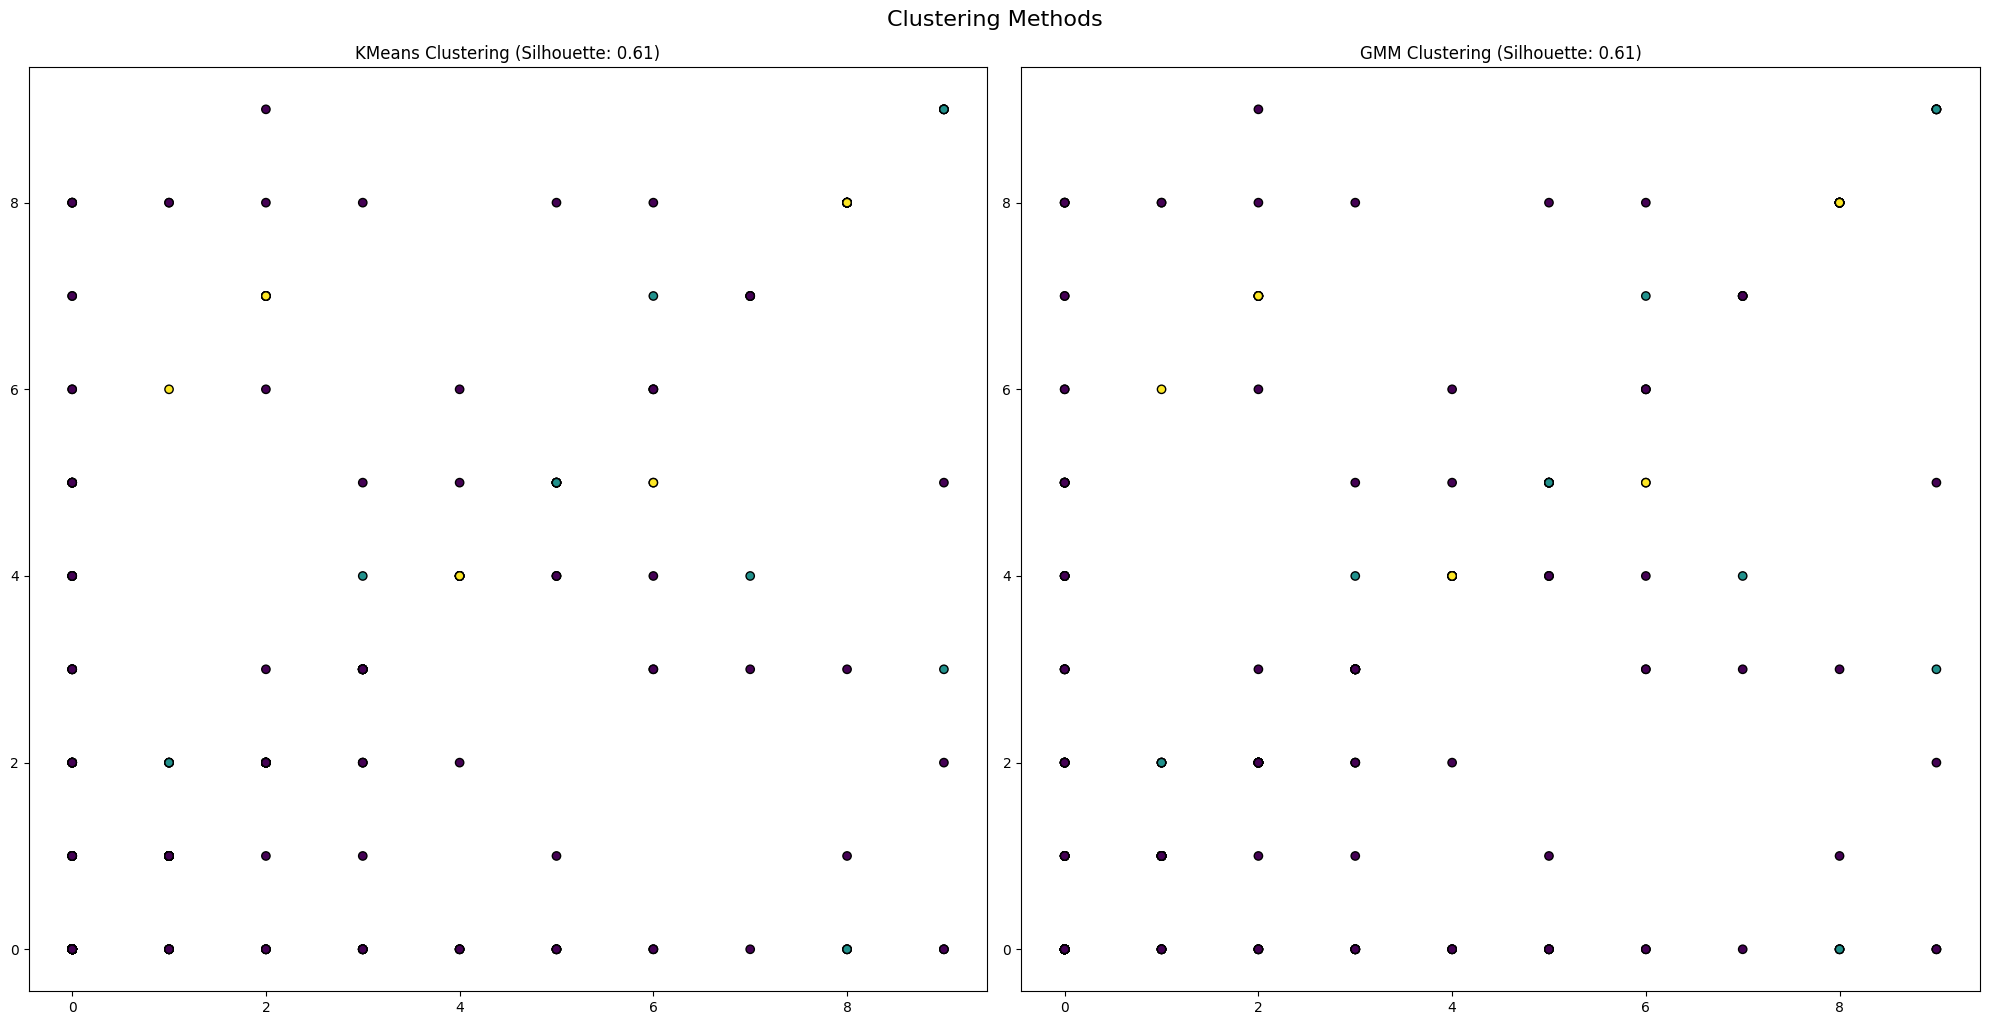

2024-07-16 22:32:25.589870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 22:32:25.590080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 22:32:25.765943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


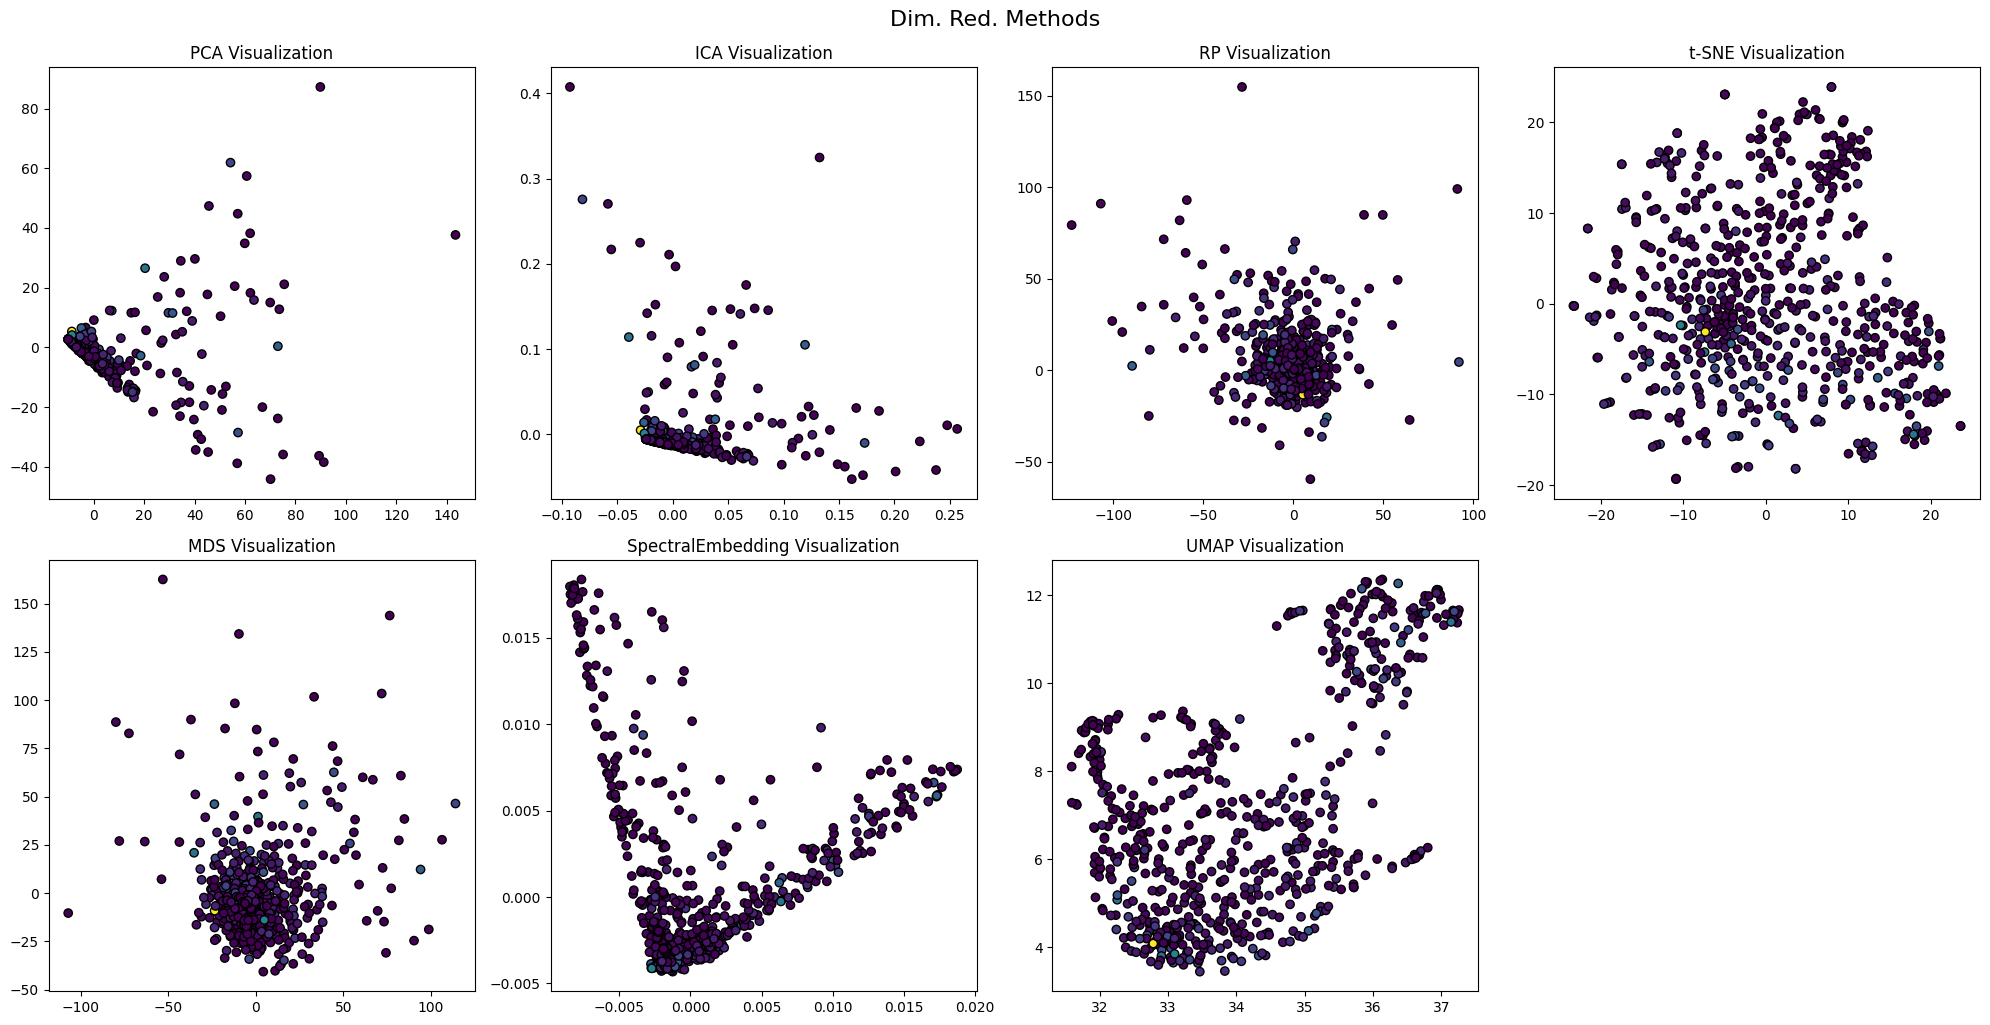

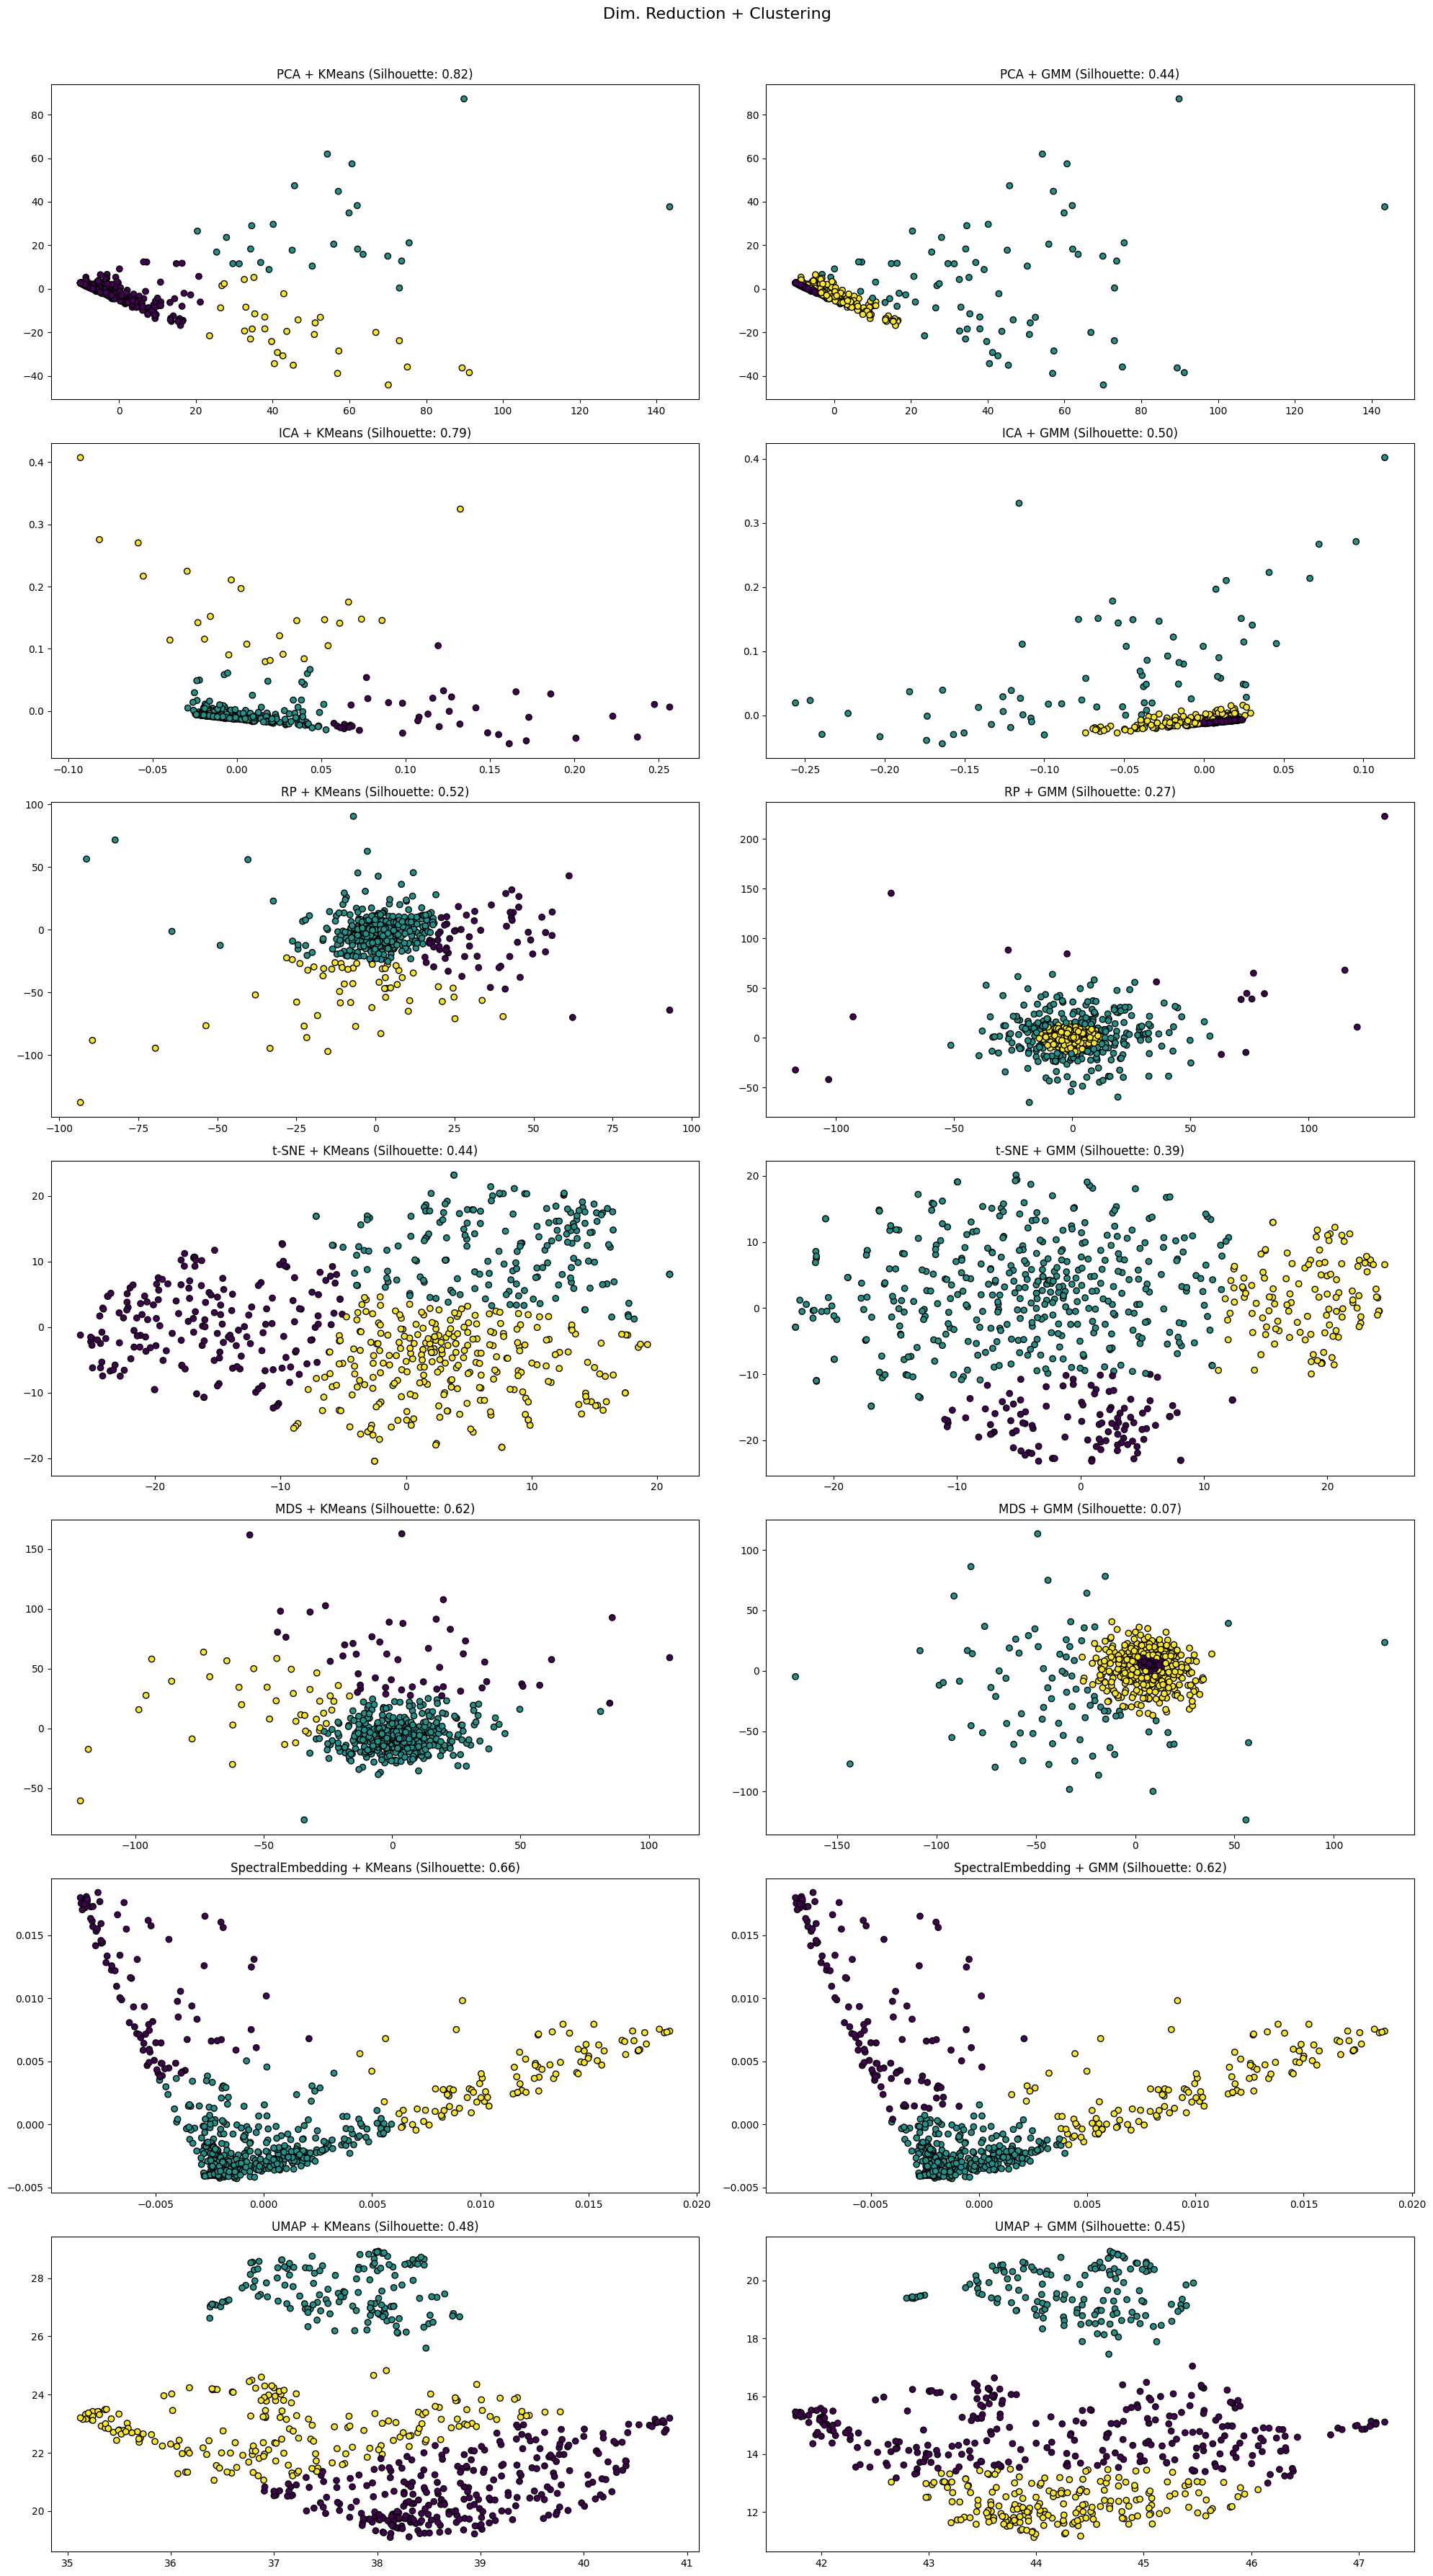

Best number of components for PCA: 111
Best number of components for ICA: 174
Best number of components for RP: 1
PCA Explained Variance Ratio: [3.11467998e-01 8.23256273e-02 4.71675973e-02 2.92525908e-02
 2.50183023e-02 2.27298790e-02 1.77739343e-02 1.58141045e-02
 1.47621010e-02 1.44495688e-02 1.25891764e-02 1.19541751e-02
 1.11472725e-02 1.04260585e-02 9.91109259e-03 9.70198891e-03
 9.17722227e-03 8.62988463e-03 8.20838245e-03 7.47547420e-03
 7.38954655e-03 7.25378561e-03 6.69030634e-03 6.58822184e-03
 6.38204096e-03 6.12390305e-03 6.04099400e-03 5.78802672e-03
 5.65637416e-03 5.61698849e-03 5.33774311e-03 5.20742155e-03
 5.02826008e-03 4.93040640e-03 4.82006591e-03 4.64619073e-03
 4.53457767e-03 4.35512856e-03 4.32594958e-03 4.24452139e-03
 4.11750488e-03 4.06323662e-03 3.99621226e-03 3.93117670e-03
 3.81337445e-03 3.76098415e-03 3.62311912e-03 3.61670974e-03
 3.56324537e-03 3.47708114e-03 3.37587878e-03 3.29947625e-03
 3.25091158e-03 3.20916026e-03 3.11045941e-03 3.04675661e-03
 2

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def load_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

def prepare_data(challenges, sample_ratio=1.00):
    data = []
    labels = []
    for task_id, task in challenges.items():
        for instance in task['train']:
            input_matrix = np.array(instance['input'])
            output_matrix = np.array(instance['output'])
            if input_matrix.shape == output_matrix.shape:
                input_flat = sum([sublist.tolist() for sublist in input_matrix if sublist.size > 0], [])
                output_flat = sum([sublist.tolist() for sublist in output_matrix if sublist.size > 0], [])
                data.append(input_flat)
                labels.append(output_flat)
    
    if len(data) == 0 or len(labels) == 0:
        raise ValueError("No data available after filtering for shape matching.")

    max_length = max(max(len(d) for d in data), max(len(l) for l in labels))
    data = np.array([np.pad(d, (0, max_length - len(d)), 'constant') for d in data], dtype=object)
    labels = np.array([np.pad(l, (0, max_length - len(l)), 'constant') for l in labels], dtype=object)
    data = np.array(data.tolist())
    labels = np.array(labels.tolist())
    sample_size = int(len(data) * sample_ratio)
    if sample_size < 2:
        raise ValueError("Sample size after filtering is too small. Increase the sample_ratio or ensure sufficient data.")
    indices = np.random.choice(len(data), sample_size, replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

def apply_dimensionality_reduction(X, method, n_components=2):
    if method == 'PCA':
        dr = PCA(n_components=n_components)
    elif method == 'ICA':
        dr = FastICA(n_components=n_components)
    elif method == 'RP':
        dr = GaussianRandomProjection(n_components=n_components)
    elif method == 't-SNE':
        perplexity = min(30, X.shape[0] - 1)
        dr = TSNE(n_components=n_components, perplexity=perplexity)
    elif method == 'MDS':
        dr = MDS(n_components=n_components)
    elif method == 'SpectralEmbedding':
        dr = SpectralEmbedding(n_components=n_components)
    elif method == 'UMAP':
        import umap
        dr = umap.UMAP(n_components=n_components)
    else:
        raise ValueError(f"Unknown method: {method}")
    X_reduced = dr.fit_transform(X)
    return X_reduced

def apply_clustering(X, method, n_clusters=3):
    if method == 'KMeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'GMM':
        model = GaussianMixture(n_components=n_clusters, random_state=42)
    else:
        raise ValueError(f"Unknown clustering method: {method}")
    clusters = model.fit_predict(X)
    return clusters

def plot_visualization_grid(ax, method, X, y):
    X_reduced = apply_dimensionality_reduction(X, method)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=np.argmax(y, axis=1), cmap='viridis', edgecolor='k')
    ax.set_title(f"{method} Visualization")

def plot_clustering_grid(ax, method, X):
    clusters = apply_clustering(X, method)
    silhouette_avg = silhouette_score(X, clusters)
    ax.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', edgecolor='k')
    ax.set_title(f"{method} Clustering (Silhouette: {silhouette_avg:.2f})")

def plot_dim_red_then_clustering(ax, dim_red_method, cluster_method, X):
    X_reduced = apply_dimensionality_reduction(X, dim_red_method)
    clusters = apply_clustering(X_reduced, cluster_method)
    silhouette_avg = silhouette_score(X_reduced, clusters)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', edgecolor='k')
    ax.set_title(f"{dim_red_method} + {cluster_method} (Silhouette: {silhouette_avg:.2f})")

def plot_in_grid(methods, plot_function, rows, cols, title_prefix, X, y=None, is_clustering=False):
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
    axs = axs.flatten()
    for i, method in enumerate(methods):
        if is_clustering:
            X_reduced = apply_dimensionality_reduction(X, method)
            plot_function(axs[i], method, X_reduced)
        else:
            if y is not None:
                plot_function(axs[i], method, X, y)
            else:
                plot_function(axs[i], method, X)
    for ax in axs[len(methods):]:
        fig.delaxes(ax)
    plt.tight_layout()
    plt.suptitle(f"{title_prefix}", y=1.02, fontsize=16)
    plt.show()

def plot_dim_red_then_clustering_grid(dim_red_methods, cluster_methods, X):
    fig, axs = plt.subplots(len(dim_red_methods), len(cluster_methods), figsize=(20, 5 * len(dim_red_methods)))
    for i, dim_red_method in enumerate(dim_red_methods):
        for j, cluster_method in enumerate(cluster_methods):
            plot_dim_red_then_clustering(axs[i, j], dim_red_method, cluster_method, X)
    plt.tight_layout()
    plt.suptitle("Dim. Reduction + Clustering", y=1.02, fontsize=16)
    plt.show()

def evaluate_pca(X):
    pca = PCA()
    pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    return explained_variance

def evaluate_ica(X):
    ica = FastICA()
    ica.fit(X)
    kurtosis = pd.DataFrame(ica.components_).kurt(axis=1).abs().values
    return kurtosis

def evaluate_rp(X):
    rp = GaussianRandomProjection(n_components=50)
    X_projected = rp.fit_transform(X)
    X_reconstructed = np.dot(X_projected, np.linalg.pinv(rp.components_.T))
    reconstruction_error = np.mean((X - X_reconstructed) ** 2)
    return reconstruction_error

def tabulate_metrics(X):
    pca_var = evaluate_pca(X)
    ica_kurt = evaluate_ica(X)
    rp_err = evaluate_rp(X)
    
    print("PCA Explained Variance Ratio:", pca_var)
    print("ICA Mean Kurtosis:", ica_kurt)
    print("RP Reconstruction Error:", rp_err)

def print_best_models_and_techniques():
    best_components_pca = choose_best_components(X_train, 'PCA')
    best_components_ica = choose_best_components(X_train, 'ICA')
    best_components_rp = choose_best_components(X_train, 'RP')
    print(f"Best number of components for PCA: {best_components_pca}")
    print(f"Best number of components for ICA: {best_components_ica}")
    print(f"Best number of components for RP: {best_components_rp}")

def choose_best_components(X, method):
    if method == 'PCA':
        explained_variance = evaluate_pca(X)
        return np.argmax(explained_variance.cumsum() >= 0.95) + 1
    elif method == 'ICA':
        kurtosis = evaluate_ica(X)
        return np.argmax(kurtosis) + 1
    elif method == 'RP':
        reconstruction_error = evaluate_rp(X)
        return np.argmin(reconstruction_error) + 1
    return 2

# Load the data
base_path = '/kaggle/input/arc-prize-2024/'
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Prepare the training data
train_data, train_labels = prepare_data(training_challenges, sample_ratio=1.00)

# Ensure we have sufficient data for training and testing
if len(train_data) < 2:
    raise ValueError("Not enough data available for training and testing. Please check the data preparation steps.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Step 1: Run clustering, then visualize data (no NN)
clustering_methods = ['KMeans', 'GMM']
plot_in_grid(clustering_methods, plot_clustering_grid, 1, 2, "Clustering Methods", X_train)

# Step 2: Run dim. red. then visualize data (no NN)
dr_methods = ['PCA', 'ICA', 'RP', 't-SNE', 'MDS', 'SpectralEmbedding', 'UMAP']
plot_in_grid(dr_methods, plot_visualization_grid, 2, 4, "Dim. Red. Methods", X_train, y_train)

# Step 3: Run dim. red., then clustering, then visualize data (no NN)
plot_dim_red_then_clustering_grid(dr_methods, clustering_methods, X_train)

# Best model and technique selection
print_best_models_and_techniques()

# Tabulate metrics
tabulate_metrics(X_train)
